In [1]:
import pandas as pd
import numpy as np
import os
import config
from sklearn.model_selection import KFold
from sklearn import preprocessing 

In [7]:
# pre-processing
import pandas as pd
import numpy as np
import os

def safe_divide(numerator, denominator, default=0.0):
    """안전한 나눗셈 헬퍼 함수"""
    if denominator > 0:
        return numerator / denominator
    return default

class DataPreprocessor:
    def __init__(self, chair_path, person_path, output_dir):
        self.chair_path = chair_path
        self.person_path = person_path
        self.output_dir = output_dir
        
        # 사용할 Chair 피처 정의
        self.categorical_features = [
            '헤드레스트 유무', '팔걸이 유무', '요추지지대 유무', 
            '높이 조절 레버 유무', '틸팅 여부', '등받이 곧/꺾'
        ]
        
        self.numerical_features = [
            'h8_지면-좌석 높이_MIN', 'h8_지면-좌석 높이_MAX',
            'b3_좌석 가로 길이', 't4_좌석 세로 길이 일반',
            'b4_등받이 가로 길이', 'h7_등받이 세로 길이'
        ]
        
        # Person 데이터의 피처 (cm -> mm 변환 필요)
        self.person_features = [
            'human-height', 'A_Buttock-popliteal length',
            'B_Popliteal-height', 'C_Hip-breadth',
            'F_Sitting-height', 'G_Shoulder-breadth'
        ]
        
        os.makedirs(output_dir, exist_ok=True)

    def load_data(self):
        """데이터 로드 및 기본 전처리"""
        # Chair 데이터 로드
        self.chair_df = pd.read_excel(self.chair_path, engine='openpyxl')
        
        # Person 데이터 로드 (cm -> mm 변환)
        self.person_df = pd.read_csv(self.person_path, encoding='utf-8')
        for col in self.person_features:
            if col in self.person_df.columns:
                self.person_df[col] *= 10  # cm to mm
        
        # 범주형 피처 전처리
        for col in self.categorical_features:
            if col in self.chair_df.columns:
                if col == '등받이 곧/꺾':
                    # '곧'=0, '꺾'=1로 매핑
                    self.chair_df[col] = self.chair_df[col].map({'곧': 0, '꺾': 1})
                else:
                    # 'O'=1, 'X'=0으로 매핑
                    self.chair_df[col] = self.chair_df[col].map({'O': 1, 'X': 0})
        
        # 결측값 처리
        # 높이 조절 범위가 없는 경우 -> MAX = MIN
        # 그 외 범주형 컬럼은 0, 수치형 컬럼은 평균값으로 대체
        self.chair_df['h8_지면-좌석 높이_MAX'] = np.where(pd.isna(self.chair_df['h8_지면-좌석 높이_MAX']),
                                                        self.chair_df['h8_지면-좌석 높이_MIN'],
                                                        self.chair_df['h8_지면-좌석 높이_MAX'])
        self.chair_df[self.categorical_features] = self.chair_df[self.categorical_features].fillna(0)
        for col in self.numerical_features:
            self.chair_df[col] = pd.to_numeric(
                self.chair_df[col].astype(str).str.strip().replace('', np.nan), 
                errors='coerce'
            ).fillna(
                pd.to_numeric(
                    self.chair_df[col].astype(str).str.strip().replace('', np.nan), 
                    errors='coerce'
                ).mean()
            )
    
    def create_feature_mappings(self):
        """피처 인덱스 매핑 생성"""
        # 수치형 피처 인덱스 (1부터 시작)
        self.feature_idx_map = {}
        idx = 1
        
        # Person 피처 (6개)
        for feat in self.person_features:
            self.feature_idx_map[f'person_{feat}'] = idx
            idx += 1
        
        # Chair 수치형 피처 (6개)
        for feat in self.numerical_features:
            self.feature_idx_map[f'chair_{feat}'] = idx
            idx += 1
        
        # 상호작용 피처 (6개 추가)
        interaction_features = [
            'height_match_score', 'width_margin_ratio', 'depth_margin_ratio',
            'backrest_height_ratio', 'shoulder_width_ratio', 'adjustable_range'
        ]
        for feat in interaction_features:
            self.feature_idx_map[feat] = idx
            idx += 1
        
        # 이진 범주형 피처 시작 오프셋
        self.binary_offset = idx
        
        # 이진 피처 인덱스 (각 피처당 2개씩: 0과 1)
        for i, feat in enumerate(self.categorical_features):
            # 각 이진 피처는 2개의 임베딩을 가짐 (0 또는 1)
            self.feature_idx_map[f'{feat}_0'] = self.binary_offset + i * 2
            self.feature_idx_map[f'{feat}_1'] = self.binary_offset + i * 2 + 1
        
        print(f"Total number of features: {len(self.feature_idx_map)}")
        print(f"Numerical features: {self.binary_offset - 1}")
        print(f"Binary categorical embeddings: {len(self.categorical_features) * 2}")

    def calculate_interaction_features(self, person_row, chair_row):
        """Person과 Chair 간의 상호작용 피처 계산"""
        features = {}
        
        # 높이 적합도 (조절 범위 내에 있는지)
        h8_mid = (chair_row['h8_지면-좌석 높이_MIN'] + chair_row['h8_지면-좌석 높이_MAX']) / 2
        h8_range = chair_row['h8_지면-좌석 높이_MAX'] - chair_row['h8_지면-좌석 높이_MIN']
        popliteal_height = person_row['B_Popliteal-height']
        
        if h8_range > 0:
            # 조절 가능한 경우
            if chair_row['h8_지면-좌석 높이_MIN'] <= popliteal_height <= chair_row['h8_지면-좌석 높이_MAX']:
                features['height_match_score'] = 1.0
            else:
                # 범위 밖인 경우 거리에 따라 점수 감소
                if popliteal_height < chair_row['h8_지면-좌석 높이_MIN']:
                    dist = chair_row['h8_지면-좌석 높이_MIN'] - popliteal_height
                else:
                    dist = popliteal_height - chair_row['h8_지면-좌석 높이_MAX']
                features['height_match_score'] = max(0, 1 - dist / 100)  # 100mm당 1점 감소
        else:
            # 고정 높이인 경우
            features['height_match_score'] = max(0, 1 - abs(h8_mid - popliteal_height) / 50)
        
        # 안전한 나눗셈 사용
        # 너비 여유율
        features['width_margin_ratio'] = safe_divide(
            chair_row['b3_좌석 가로 길이'] - person_row['C_Hip-breadth'], 
            person_row['C_Hip-breadth']
        )
        # 깊이 여유율
        features['depth_margin_ratio'] = safe_divide(
            person_row['A_Buttock-popliteal length'] - chair_row['t4_좌석 세로 길이 일반'], 
            person_row['A_Buttock-popliteal length']
        )
        # 등받이 높이 비율
        features['backrest_height_ratio'] = safe_divide(
            chair_row['h7_등받이 세로 길이'], 
            person_row['F_Sitting-height']
        )
        # 어깨 너비 비율
        features['shoulder_width_ratio'] = safe_divide(
            chair_row['b4_등받이 가로 길이'], 
            person_row['G_Shoulder-breadth']
        )
        # 조절 가능 범위
        features['adjustable_range'] = h8_range
        
        return features
    
    def check_matching_conditions(self, person_row, chair_row):
        """필수 매칭 조건 확인 및 레이블 생성"""
        conditions = {
            't4 < A': chair_row['t4_좌석 세로 길이 일반'] < person_row['A_Buttock-popliteal length'],
            'h8 ≈ B': (chair_row['h8_지면-좌석 높이_MIN'] <= person_row['B_Popliteal-height'] <= chair_row['h8_지면-좌석 높이_MAX']) 
                      if chair_row['h8_지면-좌석 높이_MAX'] > chair_row['h8_지면-좌석 높이_MIN']
                      else abs((chair_row['h8_지면-좌석 높이_MIN'] + chair_row['h8_지면-좌석 높이_MAX'])/2 - person_row['B_Popliteal-height']) < 50,
            'b3 > C': chair_row['b3_좌석 가로 길이'] > person_row['C_Hip-breadth'],
            'h7 < F': chair_row['h7_등받이 세로 길이'] < person_row['F_Sitting-height'],
            'b4 ≥ G': chair_row['b4_등받이 가로 길이'] >= person_row['G_Shoulder-breadth']
        }
        
        # 모든 조건 만족 시 1, 아니면 0
        all_satisfied = all(conditions.values())
        
        # Soft label: 만족하는 조건 수 / 전체 조건 수
        soft_label = sum(conditions.values()) / len(conditions)
        
        return int(all_satisfied), soft_label, conditions
    
    def process_data(self):
        """전체 데이터 처리 및 파일 생성"""
        self.load_data()
        self.create_feature_mappings()
        
        # 출력 파일 열기
        f_train_value = open(os.path.join(self.output_dir, 'train_x.txt'), 'w')
        f_train_index = open(os.path.join(self.output_dir, 'train_i.txt'), 'w')
        f_train_label = open(os.path.join(self.output_dir, 'train_y.txt'), 'w')
        
        cnt = 0
        positive_cnt = 0
        
        # 모든 Person-Chair 조합 생성
        for _, person in self.person_df.iterrows():
            for _, chair in self.chair_df.iterrows():
                cnt += 1
                
                # 피처 값과 인덱스 리스트
                values = []
                indices = []
                
                # 1. Person 수치형 피처
                for feat in self.person_features:
                    if feat in person.index:
                        values.append(str(person[feat]))
                        indices.append(str(self.feature_idx_map[f'person_{feat}']))
                
                # 2. Chair 수치형 피처
                for feat in self.numerical_features:
                    values.append(str(chair[feat]))
                    indices.append(str(self.feature_idx_map[f'chair_{feat}']))
                
                # 3. 상호작용 피처 계산
                interaction_feats = self.calculate_interaction_features(person, chair)
                for feat_name, feat_value in interaction_feats.items():
                    values.append(str(feat_value))
                    indices.append(str(self.feature_idx_map[feat_name]))
                
                # 4. 이진 범주형 피처 (값은 1, 인덱스는 0 또는 1에 따라 다름)
                for feat in self.categorical_features:
                    values.append('1')  # 범주형은 항상 1
                    feat_value = int(chair[feat]) if not pd.isna(chair[feat]) else 0
                    idx_key = f'{feat}_{feat_value}'
                    indices.append(str(self.feature_idx_map[idx_key]))
                
                # 5. 레이블 계산
                hard_label, soft_label, conditions = self.check_matching_conditions(person, chair)
                
                # 파일에 쓰기
                f_train_value.write(' '.join(values) + '\n')
                f_train_index.write(' '.join(indices) + '\n')
                f_train_label.write(f'{soft_label:.4f}\n')  # soft label 사용
                
                if hard_label == 1:
                    positive_cnt += 1
                
                if cnt % 1000 == 0:
                    print(f'Processed {cnt} combinations...')
        
        f_train_value.close()
        f_train_index.close()
        f_train_label.close()
        
        print(f"\nTotal combinations: {cnt}")
        print(f"Positive matches (all conditions satisfied): {positive_cnt} ({positive_cnt/cnt*100:.2f}%)")
        
        # 메타데이터 저장
        self.save_metadata()
    
    def save_metadata(self):
        """피처 매핑 정보 저장"""
        import json
        
        metadata = {
            'feature_mappings': self.feature_idx_map,
            'total_features': len(self.feature_idx_map),
            'numerical_features': self.binary_offset - 1,
            'categorical_features': self.categorical_features,
            'person_features': self.person_features,
            'chair_numerical_features': self.numerical_features
        }
        
        with open(os.path.join(self.output_dir, 'metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)

In [8]:
# 전처리 실행
preprocessor = DataPreprocessor(
    chair_path='ohouse_chair.xlsx',
    person_path='person.csv',
    output_dir='processed_data/'
)
    
preprocessor.process_data()

Total number of features: 30
Numerical features: 18
Binary categorical embeddings: 12
Processed 1000 combinations...
Processed 2000 combinations...
Processed 3000 combinations...
Processed 4000 combinations...
Processed 5000 combinations...
Processed 6000 combinations...
Processed 7000 combinations...
Processed 8000 combinations...
Processed 9000 combinations...
Processed 10000 combinations...
Processed 11000 combinations...
Processed 12000 combinations...
Processed 13000 combinations...
Processed 14000 combinations...
Processed 15000 combinations...
Processed 16000 combinations...
Processed 17000 combinations...
Processed 18000 combinations...
Processed 19000 combinations...
Processed 20000 combinations...
Processed 21000 combinations...
Processed 22000 combinations...
Processed 23000 combinations...
Processed 24000 combinations...
Processed 25000 combinations...

Total combinations: 25200
Positive matches (all conditions satisfied): 1142 (4.53%)


In [9]:
# K-fold
import numpy as np
import config  # 사용자 정의 설정 파일 (경로, 시드 등)
import os
import pandas as pd
from sklearn.model_selection import KFold
# from sklearn import preprocessing 

scale = ""
train_x_name = "train_x.npy"  # 수치형 특성 저장 파일명
train_y_name = "train_y.npy"  # 레이블 저장 파일명

Column = 18  # 데이터셋의 수치형 특성 개수

def _load_data(_nrows=None, debug = False):
    """
    train_x.txt와 train_y.txt 파일을 읽어 데이터를 로드하는 함수
    
    Args:
        nrows: 읽을 행의 수 (None이면 전체 읽기)
        debug: 디버그 모드 플래그
    
    Returns:
        train_x: 수치형 특성 배열
        train_y: 레이블 배열
    """

    # config.TRAIN_X는 train_x.txt 파일 경로
    # 공백으로 구분된 18개의 수치형 특성값을 읽음
    train_x = pd.read_csv(config.TRAIN_X,header=None,sep=' ',nrows=_nrows, dtype=np.float64)
    # config.TRAIN_Y는 train_y.txt 파일 경로
    # 각 샘플의 레이블(0 ~ 1 사이 값)을 읽음
    train_y = pd.read_csv(config.TRAIN_Y,header=None,sep=' ',nrows=_nrows, dtype=np.float64)

    # DataFrame을 numpy 배열로 변환
    train_x = train_x.values
    train_y = train_y.values.reshape([-1]) # 1차원 배열로 변환
    
    print('data loading done!')
    print('training data : %d' % train_y.shape[0])
    
    # x와 y의 샘플 수가 동일한지 확인
    assert train_x.shape[0]==train_y.shape[0]

    return train_x, train_y


def save_x_y(fold_index, train_x, train_y):
    """
    10개의 fold로 분할된 데이터를 각각 저장하는 함수

    Args:
        fold_index: 각 fold에 속하는 샘플들의 인덱스 리스트
        train_x: 전체 수치형 특성 데이터
        train_y: 전체 레이블 데이터
    """
    
    # 인덱스 리스트를 사용해 해당하는 요소(행)들을 추출
    _get = lambda x, l: [x[i] for i in l]

    for i in range(len(fold_index)):
        print("now part %d" % (i+1))
        part_index = fold_index[i] # i번째 fold의 인덱스들

        # 해당 fold의 데이터만 추출
        Xv_train_, y_train_ = _get(train_x, part_index), _get(train_y, part_index)
        
        # 저장 디렉토리 설정 (part1, part2, ..., part10)
        save_dir_Xv = config.DATA_PATH +  "part" + str(i+1) + "/"
        save_dir_y = config.DATA_PATH +  "part" + str(i+1) + "/"

        # 디렉토리가 없으면 생성
        if (os.path.exists(save_dir_Xv) == False):
            os.makedirs(save_dir_Xv)
        if (os.path.exists(save_dir_y) == False):
            os.makedirs(save_dir_y)
        
        # 파일 경로 설정 및 저장
        save_path_Xv  = save_dir_Xv + train_x_name # part*/train_x.npy
        save_path_y  = save_dir_y + train_y_name   # part*/train_y.npy
        np.save(save_path_Xv, Xv_train_)
        np.save(save_path_y, y_train_)

def save_i(fold_index):
    """
    train_i.txt 파일을 읽어 범주형 특성 인덱스를 fold별로 저장하는 함수

    Args:
        fold_index: 각 fold에 속하는 샘플들의 인덱스 리스트
    """

    _get = lambda x, l: [x[i] for i in l]
    
    # config.TRAIN_I는 train_i.txt 파일 경로
    # 범주형 특성의 인덱스 정보를 읽음
    train_i = pd.read_csv(config.TRAIN_I,header=None,sep=' ',nrows=None, dtype=np.float64) 
    train_i = train_i.values 

    # 전체 특성(feature)의 개수 계산
    # 인덱스의 최대값 + 1 = 전체 피처 개수
    feature_size = train_i.max() + 1
    print ("feature_size = %d" % feature_size) 
    feature_size = [feature_size]
    feature_size = np.array(feature_size)

    # 특성 크기 정보 저장 (모델 학습 시 필요)
    np.save(config.DATA_PATH +  "feature_size.npy", feature_size)

    print("train_i size: %d" % len(train_i))

    # 각 fold별로 범주형 특성 인덱스 저장
    for i in range(len(fold_index)):
        print("now part %d" % (i+1))
        part_index = fold_index[i]
        Xi_train_ = _get(train_i, part_index)
        save_path_Xi  = config.DATA_PATH +  "part" + str(i+1)+ '/train_i.npy'
        np.save(save_path_Xi, Xi_train_)

In [10]:
# k-fold 분할 실행
train_x, train_y = _load_data()
print('loading data done!')

# K-Fold로 10개 그룹 나눔
folds = list(KFold(n_splits=10, shuffle=True,
                    random_state=config.RANDOM_SEED).split(train_x))

fold_index = []
for i,(train_id, valid_id) in enumerate(folds):
    fold_index.append(valid_id)

print("fold num: %d" % (len(fold_index)))

# fold 인덱스를 저장
fold_index = np.array(fold_index)
np.save(config.DATA_PATH +  "fold_index.npy", fold_index)

save_x_y(fold_index, train_x, train_y) # train_x, train_y -> 각 폴더에 저장
print("save train_x_y done!")

fold_index = np.load(config.DATA_PATH +  "fold_index.npy")
save_i(fold_index) # train_i 저장
print("save index done!")

data loading done!
training data : 25200
loading data done!
fold num: 10
now part 1
now part 2
now part 3
now part 4
now part 5
now part 6
now part 7
now part 8
now part 9
now part 10
save train_x_y done!
feature_size = 31
train_i size: 25200
now part 1
now part 2
now part 3
now part 4
now part 5
now part 6
now part 7
now part 8
now part 9
now part 10
save index done!


In [11]:
# scale
import math
import config
import numpy as np

def scale(x):
    """
    개별 수치형 피처를 스케일링하는 함수

    Args:
        x: 스케일링할 수치값
    
    Returns:
        스케일링된 값
    """
    if x > 2:
        # 로그 스케일링 기법 (skew가 너무 클 때 사용)
        # x가 2보다 크면 로그 변환 후 제곱을 취한 값의 정수 부분만 반환
        # 큰 값들을 압축하여 특성값의 범위를 줄이는 효과가 있음
        x = int(math.log(float(x))**2)
    return x



def scale_each_fold():
    """
    10개의 fold에 대해 각각 스케일링을 수행하는 함수
    """

    # 1부터 10까지의 fold를 순회
    for i in range(1,11):
        print('now part %d' % i)

        # config.DATA_PATH에서 각 fold의 train_x.npy 파일을 로드
        data = np.load(config.DATA_PATH + 'part'+str(i)+'/train_x.npy')

        # data의 첫 18개 컬럼만 추출 (데이터셋의 수치형 피처들)
        part = data[:,0:18]

        # 각 행(샘플)에 대해 스케일링 수행
        for j in range(part.shape[0]):
            # 진행 상황을 확인하기 위해 100,000개마다 출력
            if j % 100 ==0:
                print(j)
            
            # 현재 행의 13개 수치형 특성에 대해 scale 함수를 적용
            # map 함수를 사용하여 각 원소에 scale 함수를 적용하고 리스트로 변환
            part[j] = list(map(scale, part[j]))
        
        # 스케일링된 데이터를 새로운 파일명(train_x2.npy)으로 저장
        # 원본 data 배열을 저장하므로 수치형 특성만 스케일링되고
        # 나머지 범주형 특성들은 그대로 유지됨
        np.save(config.DATA_PATH + 'part' + str(i) + '/train_x2.npy', data)

In [12]:
# scale 실행
scale_each_fold()

now part 1
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
now part 2
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
now part 3
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
now part 4
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
now part 5
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
now part 6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
now part 7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
now part 8
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
190

In [13]:
# DRM 구현
import tensorflow as tf
import numpy as np

class DifferentiableRankingLoss:
    """
    TensorFlow implementation of differentiable ranking metrics
    for soft labels in CTR prediction
    """
    
    @staticmethod
    def detNeuralSort(s, tau=1.0, k=2):
        """
        Deterministic neural sort
        Args:
            s: scores tensor [batch_size, n_items]
            tau: temperature parameter
            k: top-k items to consider
        Returns:
            P_hat: permutation matrix [batch_size, k, n_items]
        """
        # Get dimensions
        batch_size = tf.shape(s)[0]
        n = tf.shape(s)[1]
        
        # Expand dimensions for broadcasting
        su = tf.expand_dims(s, axis=-1)  # [batch_size, n_items, 1]
        
        # Create matrices
        one = tf.ones([n, 1], dtype=tf.float32)
        one_k = tf.ones([1, k], dtype=tf.float32)
        
        # Compute A_s = |s_i - s_j|
        A_s = tf.abs(su - tf.transpose(su, [0, 2, 1]))  # [batch_size, n, n]
        
        # Compute B
        B = tf.matmul(A_s, tf.matmul(one, one_k))  # [batch_size, n, k]
        
        # Compute scaling
        scaling = tf.cast(n + 1 - 2 * (tf.range(n) + 1), tf.float32)
        scaling = tf.expand_dims(scaling, 0)  # [1, n]
        
        # Compute C
        C = tf.expand_dims(s * scaling, -1)[:, :, :k]  # [batch_size, n, k]
        
        # Compute P_max
        P_max = tf.transpose(C - B, [0, 2, 1])  # [batch_size, k, n]
        
        # Apply softmax
        P_hat = tf.nn.softmax(P_max / tau, axis=-1)
        
        return P_hat
    
    @staticmethod
    def neuPrec(p_hat, y, k=1):
        """
        Neural Precision@k
        Args:
            p_hat: permutation matrix from detNeuralSort
            y: soft labels [batch_size, n_items]
            k: precision at k
        Returns:
            loss: negative precision loss
        """
        ysum = tf.reduce_sum(y, axis=1)
        
        # Compute precision
        prec = tf.reduce_sum(y * tf.reduce_sum(p_hat, axis=1), axis=1) / k
        
        # Apply clamp to handle empty cases
        loss = -prec * tf.clip_by_value(ysum, 0, 1)
        
        return loss
    
    @staticmethod
    def neuPrecLoss(scores, labels, topk=100, k=5, tau=10.0, use_top=True):
        """
        Neural Precision Loss
        Args:
            scores: prediction scores [batch_size, n_items]
            labels: soft labels [batch_size, n_items]
            topk: number of top items to consider
            k: precision at k
            tau: temperature for neural sort
            use_top: whether to use top-k items or random sampling
        Returns:
            loss: scalar loss value
        """
        batch_size = tf.shape(scores)[0]
        n_items = tf.shape(scores)[1]
        
        if use_top:
            # Get top-k scores and indices
            y_hat, indices = tf.nn.top_k(scores, k=tf.minimum(topk, n_items))
            
            # Gather corresponding labels
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, tf.shape(indices)[1]])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y = tf.gather_nd(labels, gather_indices)
        else:
            # Random sampling
            indices = tf.random.uniform([batch_size, topk], 0, n_items, dtype=tf.int32)
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, topk])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            
            y_hat = tf.gather_nd(scores, gather_indices)
            y = tf.gather_nd(labels, gather_indices)
        
        # Apply neural sort
        yy = DifferentiableRankingLoss.detNeuralSort(y_hat, tau=tau, k=k)
        
        # Compute loss
        ysum = tf.reduce_sum(y, axis=1)
        loss = -(tf.reduce_sum(y * tf.reduce_sum(yy, axis=1), axis=1) / k) * tf.clip_by_value(ysum, 0, 1)
        
        return tf.reduce_mean(loss)
    
    @staticmethod
    def neuMapLoss(scores, labels, topk=100, k=5, tau=10.0, use_top=True):
        """
        Neural MAP (Mean Average Precision) Loss
        """
        batch_size = tf.shape(scores)[0]
        n_items = tf.shape(scores)[1]
        
        if use_top:
            y_hat, indices = tf.nn.top_k(scores, k=tf.minimum(topk, n_items))
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, tf.shape(indices)[1]])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y = tf.gather_nd(labels, gather_indices)
        else:
            indices = tf.random.uniform([batch_size, topk], 0, n_items, dtype=tf.int32)
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, topk])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y_hat = tf.gather_nd(scores, gather_indices)
            y = tf.gather_nd(labels, gather_indices)
        
        P = DifferentiableRankingLoss.detNeuralSort(y_hat, tau=tau, k=k)
        
        pjTyToi = tf.zeros([batch_size])
        neuMap = tf.zeros([batch_size])
        
        for i in range(k):
            q = P[:, i, :]
            pjTy = tf.reduce_sum(y * q, axis=1)
            pjTyToi = pjTyToi + pjTy
            neuMap = neuMap + (pjTy * pjTyToi) / (i + 1)
        
        return -tf.reduce_mean(neuMap)
    
    @staticmethod
    def neuNDCGLoss(scores, labels, topk=100, k=5, tau=10.0, use_top=True):
        """
        Neural NDCG (Normalized Discounted Cumulative Gain) Loss
        """
        batch_size = tf.shape(scores)[0]
        n_items = tf.shape(scores)[1]
        
        # Create discount matrix
        discounts = 1 / (1 + tf.math.log(tf.range(1, k + 1, dtype=tf.float32)))
        diag = tf.linalg.diag(discounts)
        
        if use_top:
            y_hat, indices = tf.nn.top_k(scores, k=tf.minimum(topk, n_items))
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, tf.shape(indices)[1]])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y = tf.gather_nd(labels, gather_indices)
        else:
            indices = tf.random.uniform([batch_size, topk], 0, n_items, dtype=tf.int32)
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, topk])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y_hat = tf.gather_nd(scores, gather_indices)
            y = tf.gather_nd(labels, gather_indices)
        
        ysum = tf.reduce_sum(y, axis=1)
        yy = DifferentiableRankingLoss.detNeuralSort(y_hat, tau=tau, k=k)
        
        # Compute NDCG loss
        discounted_gains = tf.matmul(diag, yy)
        loss = -tf.reduce_sum(y * tf.reduce_sum(discounted_gains, axis=1), axis=1)
        loss = loss * tf.clip_by_value(ysum, 0, 1) * (1 / (1e-10 + tf.reduce_sum(y, axis=1)))
        
        return tf.reduce_mean(loss)


class AutoIntWithRankingLoss:
    """
    Modified AutoInt model initialization with ranking loss
    """
    
    def _init_graph(self):
        """Initialize computation graph with ranking loss"""
        with tf.Graph().as_default():
            # ... existing initialization code ...
            
            # Model output (scores for ranking)
            self.out = tf.nn.sigmoid(self.y)  # Ensure output is in [0, 1]
            
            # Loss type selection
            if self.loss_type == "logloss":
                self.loss = tf.losses.log_loss(self.label, self.out)
            elif self.loss_type == "mse":
                self.loss = tf.reduce_mean(tf.square(self.out - self.label))
            elif self.loss_type == "ranking_prec":
                # Reshape outputs for ranking loss
                # Assuming batch processing where each sample has multiple items
                self.loss = DifferentiableRankingLoss.neuPrecLoss(
                    self.out, self.label, 
                    topk=self.ranking_topk,
                    k=self.ranking_k,
                    tau=self.ranking_tau
                )
            elif self.loss_type == "ranking_map":
                self.loss = DifferentiableRankingLoss.neuMapLoss(
                    self.out, self.label,
                    topk=self.ranking_topk,
                    k=self.ranking_k,
                    tau=self.ranking_tau
                )
            elif self.loss_type == "ranking_ndcg":
                self.loss = DifferentiableRankingLoss.neuNDCGLoss(
                    self.out, self.label,
                    topk=self.ranking_topk,
                    k=self.ranking_k,
                    tau=self.ranking_tau
                )
            else:
                raise ValueError(f"Unknown loss type: {self.loss_type}")
            
            # Add L2 regularization
            if self.l2_reg > 0:
                self.loss += tf.add_n([tf.nn.l2_loss(w) for w in self.weights.values()]) * self.l2_reg
            
            # ... rest of the initialization code ...


# Example usage in your training code:
def create_autoint_with_ranking(args, feature_size, run_cnt):
    """
    Create AutoInt model with ranking loss support
    """
    # Add ranking-specific parameters to args
    args.loss_type = 'ranking_ndcg'  # or 'ranking_prec', 'ranking_map'
    args.ranking_topk = 100
    args.ranking_k = 5
    args.ranking_tau = 10.0
    
    # Create model (you'll need to modify AutoInt class to accept these parameters)
    model = AutoInt(args, feature_size, run_cnt)
    
    return model


# For evaluation with soft labels, modify eval_metric:
def eval_metric_soft_labels(self, y_true, y_pred):
    """
    Evaluation metric for soft labels
    Since AUC requires binary labels, we can:
    1. Use thresholding
    2. Use ranking metrics like NDCG
    """
    y_pred = np.array(y_pred).ravel()
    
    # Option 1: Convert to binary for AUC
    # Threshold at 0.5 or use multiple thresholds
    if self.eval_with_auc:
        y_true_binary = (y_true >= 0.5).astype(int)
        if len(np.unique(y_true_binary)) > 1:
            return roc_auc_score(y_true_binary, y_pred)
        else:
            return 0.5
    
    # Option 2: Use NDCG for ranking evaluation
    else:
        from sklearn.metrics import ndcg_score
        # Reshape for NDCG calculation
        # Assuming batch evaluation
        return ndcg_score(y_true.reshape(1, -1), y_pred.reshape(1, -1))

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

class LearningCurveVisualizer:
    """
    학습 곡선 시각화를 위한 클래스
    """
    def __init__(self, save_dir='./plots'):
        self.save_dir = save_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
    def plot_learning_curves(self, model, run_id=1, show_plots=True):
        """
        모델의 학습 곡선을 그리는 메인 함수
        
        Args:
            model: AutoInt 모델 인스턴스
            run_id: 실행 번호
            show_plots: 그래프를 화면에 표시할지 여부
        """
        # 데이터 준비
        train_results = np.array(model.train_result)
        valid_results = np.array(model.valid_result)
        train_losses = np.array(model.train_loss)
        valid_losses = np.array(model.valid_loss)
        
        epochs = range(1, len(train_results) + 1)
        
        # Figure 생성 (2x2 subplot)
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Learning Curves - Run {run_id}', fontsize=16)
        
        # 1. Performance Metric (우상향) - e.g., NDCG, Accuracy, Correlation
        ax1 = axes[0, 0]
        ax1.plot(epochs, train_results, 'b-', label='Train', linewidth=2, marker='o', markersize=6)
        ax1.plot(epochs, valid_results, 'r-', label='Validation', linewidth=2, marker='s', markersize=6)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Performance Metric', fontsize=12)
        ax1.set_title('Model Performance', fontsize=14)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Best point 표시
        best_valid_idx = np.argmax(valid_results)
        ax1.scatter(epochs[best_valid_idx], valid_results[best_valid_idx], 
                   color='green', s=200, marker='*', zorder=5, 
                   label=f'Best: {valid_results[best_valid_idx]:.4f}')
        ax1.legend(fontsize=12)
        
        # 2. Loss (우하향)
        ax2 = axes[0, 1]
        ax2.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o', markersize=6)
        ax2.plot(epochs, valid_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=6)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.set_title('Loss Curves', fontsize=14)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Best point 표시
        best_loss_idx = np.argmin(valid_losses)
        ax2.scatter(epochs[best_loss_idx], valid_losses[best_loss_idx], 
                   color='green', s=200, marker='*', zorder=5,
                   label=f'Best: {valid_losses[best_loss_idx]:.4f}')
        ax2.legend(fontsize=12)
        
        # 3. Overfitting Detection Plot
        ax3 = axes[1, 0]
        performance_gap = train_results - valid_results
        ax3.plot(epochs, performance_gap, 'g-', linewidth=2, marker='d', markersize=6)
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax3.set_xlabel('Epoch', fontsize=12)
        ax3.set_ylabel('Train - Validation Gap', fontsize=12)
        ax3.set_title('Overfitting Detection (Performance)', fontsize=14)
        ax3.grid(True, alpha=0.3)
        
        # 위험 구간 표시
        if np.any(performance_gap > 0.05):  # 5% 이상 차이
            ax3.axhspan(0.05, np.max(performance_gap), alpha=0.2, color='red', 
                       label='Overfitting Zone')
            ax3.legend(fontsize=12)
        
        # 4. Loss Gap
        ax4 = axes[1, 1]
        loss_gap = valid_losses - train_losses
        ax4.plot(epochs, loss_gap, 'purple', linewidth=2, marker='d', markersize=6)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Epoch', fontsize=12)
        ax4.set_ylabel('Validation - Train Loss Gap', fontsize=12)
        ax4.set_title('Overfitting Detection (Loss)', fontsize=14)
        ax4.grid(True, alpha=0.3)
        
        # 조정
        plt.tight_layout()
        
        # 저장
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'{self.save_dir}/learning_curves_run{run_id}_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Learning curves saved to: {filename}")
        
        if show_plots:
            plt.show()
        else:
            plt.close()
            
        return fig
    
    def plot_multiple_runs(self, all_results, metric_name='Performance'):
        """
        여러 실행의 결과를 비교하는 그래프
        
        Args:
            all_results: dict with keys 'train_results', 'valid_results', 'train_losses', 'valid_losses'
                        각각은 리스트의 리스트 (runs x epochs)
            metric_name: 성능 지표 이름
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Performance metrics
        for i, (train_res, valid_res) in enumerate(zip(all_results['train_results'], 
                                                       all_results['valid_results'])):
            epochs = range(1, len(train_res) + 1)
            ax1.plot(epochs, train_res, '--', alpha=0.5, label=f'Train Run {i+1}')
            ax1.plot(epochs, valid_res, '-', alpha=0.7, label=f'Valid Run {i+1}')
        
        # 평균 계산
        avg_train = np.mean(all_results['train_results'], axis=0)
        avg_valid = np.mean(all_results['valid_results'], axis=0)
        epochs = range(1, len(avg_train) + 1)
        
        ax1.plot(epochs, avg_train, 'b-', linewidth=3, label='Avg Train')
        ax1.plot(epochs, avg_valid, 'r-', linewidth=3, label='Avg Valid')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel(metric_name)
        ax1.set_title(f'{metric_name} Across Multiple Runs')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # Loss
        for i, (train_loss, valid_loss) in enumerate(zip(all_results['train_losses'], 
                                                         all_results['valid_losses'])):
            epochs = range(1, len(train_loss) + 1)
            ax2.plot(epochs, train_loss, '--', alpha=0.5)
            ax2.plot(epochs, valid_loss, '-', alpha=0.7)
        
        avg_train_loss = np.mean(all_results['train_losses'], axis=0)
        avg_valid_loss = np.mean(all_results['valid_losses'], axis=0)
        epochs = range(1, len(avg_train_loss) + 1)
        
        ax2.plot(epochs, avg_train_loss, 'b-', linewidth=3, label='Avg Train Loss')
        ax2.plot(epochs, avg_valid_loss, 'r-', linewidth=3, label='Avg Valid Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Loss Across Multiple Runs')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'{self.save_dir}/multiple_runs_comparison_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Multiple runs comparison saved to: {filename}")
        
        plt.show()
        
        return fig
    
    def plot_detailed_metrics(self, model, additional_metrics=None):
        """
        더 상세한 메트릭들을 시각화
        
        Args:
            model: AutoInt 모델
            additional_metrics: dict with keys as metric names and values as lists
        """
        n_metrics = 2 + (len(additional_metrics) if additional_metrics else 0)
        fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
        
        if n_metrics == 1:
            axes = [axes]
        
        epochs = range(1, len(model.train_result) + 1)
        
        # 기본 메트릭들
        # 1. Performance metric distribution
        ax = axes[0]
        ax.boxplot([model.train_result, model.valid_result], 
                  labels=['Train', 'Validation'])
        ax.set_ylabel('Performance Distribution')
        ax.set_title('Performance Metric Distribution')
        ax.grid(True, alpha=0.3)
        
        # 2. Learning rate (성능 변화율)
        ax = axes[1]
        if len(model.valid_result) > 1:
            valid_improvement = np.diff(model.valid_result)
            ax.plot(epochs[1:], valid_improvement, 'g-', marker='o')
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Improvement')
            ax.set_title('Epoch-to-Epoch Improvement')
            ax.grid(True, alpha=0.3)
        
        # 추가 메트릭들
        if additional_metrics:
            for idx, (metric_name, metric_values) in enumerate(additional_metrics.items()):
                ax = axes[2 + idx]
                ax.plot(epochs[:len(metric_values)], metric_values, marker='o')
                ax.set_xlabel('Epoch')
                ax.set_ylabel(metric_name)
                ax.set_title(f'{metric_name} over Epochs')
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'{self.save_dir}/detailed_metrics_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        return fig


# AutoInt 클래스에 추가할 메소드
def plot_training_history(self):
    """
    AutoInt 모델의 학습 이력을 시각화
    """
    visualizer = LearningCurveVisualizer()
    visualizer.plot_learning_curves(self, run_id=self.run_cnt)


# 사용 예시 코드
def visualize_training_results(model, run_id=1):
    """
    학습 완료 후 결과 시각화
    """
    visualizer = LearningCurveVisualizer(save_dir='./plots')
    
    # 기본 학습 곡선
    visualizer.plot_learning_curves(model, run_id=run_id)
    
    # 추가 메트릭이 있는 경우
    # additional_metrics = {
    #     'MSE': model.mse_history,
    #     'Spearman': model.spearman_history
    # }
    # visualizer.plot_detailed_metrics(model, additional_metrics)
    
    return visualizer


# 여러 실행 결과를 모아서 비교
def compare_multiple_runs(models_list):
    """
    여러 번 실행한 모델들의 결과 비교
    """
    all_results = {
        'train_results': [model.train_result for model in models_list],
        'valid_results': [model.valid_result for model in models_list],
        'train_losses': [model.train_loss for model in models_list],
        'valid_losses': [model.valid_loss for model in models_list]
    }
    
    visualizer = LearningCurveVisualizer()
    visualizer.plot_multiple_runs(all_results)

In [19]:
# model

'''
Tensorflow implementation of AutoInt described in:
AutoInt: Automatic Feature Interaction Learning via Self-Attentive Neural Networks.
author: Chence Shi
email: chenceshi@pku.edu.cn
'''
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import tensorflow as tf
from time import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, log_loss
# from tensorflow.contrib.layers.python.layers import batch_norm as batch_norm
# from tensorflow.compat.v1.layers import batch_normalization as batch_norm
from tensorflow.keras.layers import BatchNormalization


def normalize(inputs, epsilon=1e-8):
    '''
    Layer Normalization을 적용하는 함수

    Args:
        inputs: 2차원 이상의 텐서
        epsilon: 0으로 나누는 것을 방지하기 위한 작은 값
    Returns:
        입력과 동일한 shape의 정규화된 텐서
    '''
    
    inputs_shape = inputs.get_shape()
    params_shape = inputs_shape[-1:] # 마지막 차원의 크기

    mean, variance = tf.nn.moments(inputs, [-1], keepdims=True) # 평균과 분산 계산
    beta = tf.Variable(tf.zeros(params_shape)) # shift parameter
    gamma = tf.Variable(tf.ones(params_shape)) # scale parameter
    normalized = (inputs - mean) / ((variance + epsilon) ** (.5)) # 정규화
    outputs = gamma * normalized + beta # scale and shift

    return outputs

        
def multihead_attention(queries,
                        keys,
                        values,
                        num_units=None,
                        num_heads=1,
                        dropout_keep_prob=1,
                        is_training=True,
                        has_residual=True):
    '''
    Multi-head Self-Attention 메커니즘 구현
    AutoInt의 핵심 컴포넌트로, 특성 간의 고차 상호작용을 학습
    '''

    if num_units is None:
        num_units = queries.get_shape().as_list()[-1]

    # Linear projections (Q, K, V 생성)
    # ReLU 활성화 함수 추가
    Q = tf.keras.layers.Dense(num_units, activation=tf.nn.relu)(queries)
    K = tf.keras.layers.Dense(num_units, activation=tf.nn.relu)(keys)
    V = tf.keras.layers.Dense(num_units, activation=tf.nn.relu)(values)
    if has_residual:
        V_res = tf.keras.layers.Dense(num_units, activation=tf.nn.relu)(values) # residual connection용

    # Split and concat
    # Multi-head를 위해 텐서를 분할하고 재결합
    # [batch_size, seq_len, d_model] -> [batch_size*num_heads, seq_len, d_model/num_heads]
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)

    # Multiplication
    # Attention weights 계산: Q * K^T
    weights = tf.matmul(Q_, tf.transpose(K_, [0, 2, 1]))

    # Scale
    # Attention weights를 sqrt(d_k)로 나눔 (gradient 안정화)
    weights = weights / (K_.get_shape().as_list()[-1] ** 0.5)

    # Activation
    # Softmax로 attention 확률 계산
    weights = tf.nn.softmax(weights)

    # Dropouts
    # weights = tf.keras.layers.Dropout(rate=1-dropout_keep_prob)(weights, training=is_training)
    weights = tf.cond(is_training,
                      lambda: tf.nn.dropout(weights, keep_prob=dropout_keep_prob),
                      lambda: weights)


    # Weighted sum
    # Attention weights와 V를 곱함
    outputs = tf.matmul(weights, V_)

    # Restore shape
    # Multi-head 결과를 다시 결합
    # [batch_size*num_heads, seq_len, d_v] -> [batch_size, seq_len, d_model]
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)

    # Residual connection
    if has_residual:
        outputs += V_res

    outputs = tf.nn.relu(outputs) # ReLU 활성화
    outputs = normalize(outputs) # Layer normalization
        
    return outputs


class AutoInt():
    def __init__(self, args, feature_size, run_cnt):
        """
        AutoInt 모델 초기화

        주요 파라미터:
        - feature_size: 전체 특성의 개수 (범주형 특성의 one-hot 인코딩 후 차원)
        - field_size: 특성 필드의 개수 (M)
        - embedding_size: 각 특성의 임베딩 차원 (d)
        - blocks: attention 블록의 개수
        - heads: multi-head attention의 head 개수
        """

        self.feature_size = int(feature_size)             # 전체 특성 개수 (n)
        self.field_size = args.field_size            # 특성 필드 개수 (M)
        self.run_cnt = run_cnt
        self.embedding_size = int(args.embedding_size)    # 임베딩 차원 (d)
        self.blocks = args.blocks                    # attention 블록 개수
        self.heads = args.heads                      # attention head 개수
        self.block_shape = args.block_shape          # 각 블록의 출력 차원
        self.output_size = args.block_shape[-1]      # 최종 블록의 출력 차원
        self.has_residual = args.has_residual        # residual connection 사용 여부
        self.deep_layers = args.deep_layers          # DNN 레이어 구조 (선택적)
        # Ranking loss 관련 파라미터 추가
        self.loss_type = args.loss_type  # 'ranking_ndcg', 'ranking_prec', 'ranking_map'
        self.ranking_topk = getattr(args, 'ranking_topk', 100)
        self.ranking_k = getattr(args, 'ranking_k', 5)
        self.ranking_tau = getattr(args, 'ranking_tau', 10.0)

        # 학습 관련 하이퍼파라미터
        self.batch_norm = args.batch_norm
        self.batch_norm_decay = args.batch_norm_decay
        self.drop_keep_prob = args.dropout_keep_prob
        self.l2_reg = args.l2_reg
        self.epoch = args.epoch
        self.batch_size = args.batch_size
        self.learning_rate = args.learning_rate
        self.optimizer_type = args.optimizer_type

        # 모델 저장 경로
        self.save_path = args.save_path + str(run_cnt) + '/'
        self.is_save = args.is_save
        if (args.is_save == True and os.path.exists(self.save_path) == False):
            os.makedirs(self.save_path)	

        self.verbose = args.verbose
        self.random_seed = args.random_seed
        self.loss_type = args.loss_type
        self.eval_metric = roc_auc_score
        self.best_loss = 1.0
        self.greater_is_better = args.greater_is_better
        self.train_result, self.valid_result = [], []
        self.train_loss, self.valid_loss = [], []
        
        self._init_graph()

        
    def _init_graph(self):
        """
        TensorFlow 계산 그래프 초기화
        """
        self.graph = tf.Graph()
        with self.graph.as_default():

            tf.set_random_seed(self.random_seed)
            # tf.random.set_seed(self.random_seed)

            # 입력 placeholder 정의
            self.feat_index = tf.placeholder(tf.int32, shape=[None, None],
                                                 name="feat_index")  # [batch_size, field_size]: None * M
            self.feat_value = tf.placeholder(tf.float32, shape=[None, None],
                                                 name="feat_value")  # [batch_size, field_size]: None * M
            self.label = tf.placeholder(tf.float32, shape=[None, 1], name="label")  # [batch_size, 1]: None * 1

            # Dropout keep probability (3개: attention, embedding, DNN)
            self.dropout_keep_prob = tf.placeholder(tf.float32, shape=[None], name="dropout_keep_prob")
            self.train_phase = tf.placeholder(tf.bool, name="train_phase")

            self.weights = self._initialize_weights()

            # ============ model 구조 ============
            # 1. Embedding layer
            # feat_index로 임베딩 lookup
            self.embeddings = tf.nn.embedding_lookup(self.weights["feature_embeddings"],
                                                             self.feat_index)  # [batch_size, M, d]: None * M * d
            # 디버깅을 위한 shape 출력
            tf.print("embeddings shape:", tf.shape(self.embeddings))
            
            
            # feat_value를 곱해서 수치형 특성값 반영
            # feat_value reshape - 동적으로 처리
            feat_value = tf.reshape(self.feat_value, shape=[-1, tf.shape(self.feat_index)[1], 1])
            # feat_value = tf.reshape(self.feat_value, shape=[-1, self.field_size, 1])
            self.embeddings = tf.multiply(self.embeddings, feat_value)      # [batch_size, M, d]: None * M * d
            self.embeddings = tf.nn.dropout(self.embeddings, self.dropout_keep_prob[1]) # None * M * d
            
            # 2. DNN 부분 (선택적)
            # joint training with feedforward nn
            if self.deep_layers != None:
                # 임베딩을 flatten
                self.y_dense = tf.reshape(self.embeddings, shape=[-1, self.field_size * self.embedding_size])
                
                # BatchNormalization 레이어들을 저장할 리스트
                self.bn_layers = []

                # DNN layers
                for i in range(0, len(self.deep_layers)):
                    self.y_dense = tf.add(tf.matmul(self.y_dense, self.weights["layer_%d" %i]), self.weights["bias_%d"%i]) # None * layer[i]
                    if self.batch_norm:
                        # BatchNormalization 레이어 생성 및 저장
                        bn_layer = BatchNormalization(
                            momentum = self.batch_norm_decay,
                            epsilon = 1e-5,
                            center = True,
                            scale = True,
                            name = "bn_%d" % i
                        )
                        self.bn_layers.append(bn_layer)
                        self.y_dense = bn_layer(self.y_dense, training=self.train_phase)
                        # self.y_dense = self.batch_norm_layer(self.y_dense, train_phase=self.train_phase, scope_bn="bn_%d" %i)
                    self.y_dense = tf.nn.relu(self.y_dense)
                    self.y_dense = tf.nn.dropout(self.y_dense, self.dropout_keep_prob[2])
                # DNN 최종 출력
                self.y_dense = tf.add(tf.matmul(self.y_dense, self.weights["prediction_dense"]),
                                      self.weights["prediction_bias_dense"], name='logits_dense')  # None * 1
            
            
            # 3. AutoInt 핵심 부분: Multi-head Self-Attention
            self.y_deep = self.embeddings # [batch_size, M, d]: None * M * d
            for i in range(self.blocks):   
                self.y_deep = multihead_attention(queries=self.y_deep,
                                                  keys=self.y_deep,         # self-attention
                                                  values=self.y_deep,
                                                  num_units=self.block_shape[i],
                                                  num_heads=self.heads,
                                                  dropout_keep_prob=self.dropout_keep_prob[0],
                                                  is_training=self.train_phase,
                                                  has_residual=self.has_residual)

            # flatten 전에 shape 확인
            tf.print("y_deep shape before flatten:", tf.shape(self.y_deep))
            
            # Attention 출력을 flatten
            # batch_size = tf.shape(self.y_deep)[0]
            # field_size = tf.shape(self.y_deep)[1]
            # last_dim = tf.shape(self.y_deep)[2]
            # self.flat = tf.reshape(self.y_deep, [batch_size, field_size * last_dim])
            # self.flat = tf.keras.layers.Flatten()(self.y_deep)
            # self.flat = tf.reshape(self.y_deep, shape=[-1, self.field_size * self.embedding_size])
            self.flat = tf.reshape(self.y_deep, [tf.shape(self.y_deep)[0], -1])
            # self.flat = tf.reshape(self.y_deep, shape=[-1, self.output_size * self.field_size]) 

            # flatten 후 shape 확인
            tf.print("flat shape:", tf.shape(self.flat))

            # 최종 예측
            # 출력층 수정 (ranking score로 사용)
            self.y = tf.add(tf.matmul(self.flat, self.weights['prediction']), self.weights['prediction_bias'], name='logits')
            self.out = tf.nn.sigmoid(self.y)  # [0, 1] 범위로 정규화
            # self.out = tf.add(tf.matmul(self.flat, self.weights["prediction"]), 
            #                   self.weights["prediction_bias"], name='logits')  # None * 1
            # Sigmoid를 적용하여 [0, 1] 범위로 정규화
            self.out = tf.nn.sigmoid(self.y)

            # DNN과 AutoInt 결합 (선택적)
            if self.deep_layers != None:
                self.out += self.y_dense
        
            # ============ 손실 함수 정의 ============
            # Ranking loss 적용
            if self.loss_type == "ranking_ndcg":
                self.loss = DifferentiableRankingLoss.neuNDCGLoss(
                    self.out, self.label,
                    topk=self.ranking_topk,
                    k=self.ranking_k,
                    tau=self.ranking_tau
                )
            # loss
            if self.loss_type == "logloss":
                self.out = tf.nn.sigmoid(self.out, name='pred')
                self.loss = tf.losses.log_loss(self.label, self.out)
            elif self.loss_type == "mse":
                self.loss = tf.nn.l2_loss(tf.subtract(self.label, self.out))
            elif self.loss_type == "ranking_ndcg":
                # Ranking loss를 위해서는 배치 내에서 여러 아이템을 비교해야 함
                # 현재 구조에서는 각 샘플이 독립적이므로, 
                # 배치를 ranking 그룹으로 재구성해야 함
                
                # 간단한 대안: soft label에 대한 weighted loss 사용
                # soft label을 가중치로 사용하는 방식
                self.loss = tf.reduce_mean(
                    self.label * tf.losses.log_loss(tf.ones_like(self.label), self.out, reduction=tf.losses.Reduction.NONE) +
                    (1 - self.label) * tf.losses.log_loss(tf.zeros_like(self.label), self.out, reduction=tf.losses.Reduction.NONE)
                )
            else:
                raise ValueError(f"Unknown loss type: {self.loss_type}")

            # l2 정규화
            if self.l2_reg > 0:
                # weights 딕셔너리에서 정규화할 가중치들 선택
                reg_weights = []
                for name, weight in self.weights.items():
                    if 'bias' not in name:  # bias는 일반적으로 정규화하지 않음
                        reg_weights.append(weight)
                
                if reg_weights:
                    self.loss += tf.add_n([tf.nn.l2_loss(w) for w in reg_weights]) * self.l2_reg
            # if self.l2_reg > 0:
            #     if self.deep_layers != None:
            #         for i in range(len(self.deep_layers)):
            #             self.loss += l2(self.l2_reg)(self.weights["layer_%d"%i])
                        # self.loss += tf.contrib.layers.l2_regularizer(
                                                    # self.l2_reg)(self.weights["layer_%d"%i])
         
           
            # Optimizer 설정
            self.global_step = tf.Variable(0, name="global_step", trainable=False)
            self.var1 = [v for v in tf.trainable_variables() if v.name != 'feature_bias:0']
            self.var2 = [tf.trainable_variables()[1]]    # self.var2 = [feature_bias]

            if self.optimizer_type == "adam":
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, 
                                                    beta1=0.9, beta2=0.999, epsilon=1e-8).\
                                                    minimize(self.loss, global_step=self.global_step)
            elif self.optimizer_type == "adagrad":
                self.optimizer = tf.train.AdagradOptimizer(learning_rate=self.learning_rate,
                                                           initial_accumulator_value=1e-8).\
                                                           minimize(self.loss, global_step=self.global_step)
            elif self.optimizer_type == "gd":
                self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).\
                                                                   minimize(self.loss, global_step=self.global_step)
            elif self.optimizer_type == "momentum":
                self.optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.95).\
                                                            minimize(self.loss, global_step=self.global_step)

            # 초기화
            self.saver = tf.train.Saver(max_to_keep=5)
            init = tf.global_variables_initializer()
            self.sess = self._init_session()
            self.sess.run(init)
            self.count_param()


    def count_param(self):
        """모델의 전체 파라미터 개수 계산"""
        k = (np.sum([np.prod(v.get_shape().as_list()) 
                                                    for v in tf.trainable_variables()]))

        print("total parameters :%d" % k) 
        print("extra parameters : %d" % (k - self.feature_size * self.embedding_size))
        

    def _init_session(self):
        """TensorFlow 세션 초기화"""
        config = tf.ConfigProto(allow_soft_placement=True)
        config.gpu_options.allow_growth = True  # GPU 메모리를 필요한 만큼만 사용
        return tf.Session(config=config)


    def _initialize_weights(self):
        """모델 가중치 초기화"""
        weights = dict()

        # 특성 임베딩 테이블
        weights["feature_embeddings"] = tf.Variable(
            tf.random_normal([self.feature_size, self.embedding_size], 0.0, 0.01),
            name="feature_embeddings")  # [n, d]: feature_size(n) * d

        if self.blocks > 0:
            final_attention_size = self.block_shape[-1] * self.field_size
            input_size = final_attention_size
        else:
            input_size = self.embedding_size * self.field_size

        # dense layers: DNN 레이어 가중치 (선택적)
        if self.deep_layers != None:
            num_layer = len(self.deep_layers)
            layer0_size = self.field_size * self.embedding_size
            # Xavier/Glorot 초기화
            glorot = np.sqrt(2.0 / (layer0_size + self.deep_layers[0]))
            weights["layer_0"] = tf.Variable(
                np.random.normal(loc=0, scale=glorot, size=(layer0_size, self.deep_layers[0])), dtype=np.float32)
            weights["bias_0"] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(1, self.deep_layers[0])),
                                                            dtype=np.float32)  # 1 * layers[0]
            # 나머지 DNN 레이어들
            for i in range(1, num_layer):
                glorot = np.sqrt(2.0 / (self.deep_layers[i-1] + self.deep_layers[i]))
                weights["layer_%d" % i] = tf.Variable(
                    np.random.normal(loc=0, scale=glorot, size=(self.deep_layers[i-1], self.deep_layers[i])),
                    dtype=np.float32)  # layers[i-1] * layers[i]
                weights["bias_%d" % i] = tf.Variable(
                    np.random.normal(loc=0, scale=glorot, size=(1, self.deep_layers[i])),
                    dtype=np.float32)  # 1 * layer[i]
            # DNN 최종 출력층
            glorot = np.sqrt(2.0 / (self.deep_layers[-1] + 1))
            weights["prediction_dense"] = tf.Variable(
                                np.random.normal(loc=0, scale=glorot, size=(self.deep_layers[-1], 1)),
                                dtype=np.float32, name="prediction_dense")
            weights["prediction_bias_dense"] = tf.Variable(
                                np.random.normal(), dtype=np.float32, name="prediction_bias_dense")


        # AutoInt 최종 예측층 가중치
        glorot = np.sqrt(2.0 / (input_size + 1))
        weights["prediction"] = tf.Variable(
                            np.random.normal(loc=0, scale=glorot, size=(input_size, 1)),
                            dtype=np.float32, name="prediction")
        weights["prediction_bias"] = tf.Variable(
                            np.random.normal(), dtype=np.float32, name="prediction_bias")

        return weights

    def batch_norm_layer(self, x, train_phase, scope_bn):
        """Batch Normalization 레이어 (TensorFlow 2.x 버전)"""
        # BatchNormalization 레이어 생성
        bn_layer = BatchNormalization(
            momentum=self.batch_norm_decay,
            epsilon=1e-5,
            center=True,
            scale=True,
            name=scope_bn
        )
        # bn_train = batch_norm(x, decay=self.batch_norm_decay, center=True, scale=True, updates_collections=None,
        #         is_training=True, reuse=None, trainable=True, scope=scope_bn)
        # bn_inference = batch_norm(x, decay=self.batch_norm_decay, center=True, scale=True, updates_collections=None,
        #         is_training=False, reuse=True, trainable=True, scope=scope_bn)
        # # 학습/추론 모드에 따라 다른 BN 적용
        # z = tf.cond(train_phase, lambda: bn_train, lambda: bn_inference)
        
        # training 파라미터로 학습/추론 모드 구분
        return bn_layer(x, training=train_phase)

    
    def get_batch(self, Xi, Xv, y, batch_size, index):
        """배치 데이터 추출"""
        start = index * batch_size
        end = (index+1) * batch_size
        end = end if end < len(y) else len(y)
        return Xi[start:end], Xv[start:end], [[y_] for y_ in y[start:end]]


    def shuffle_in_unison_scary(self, a, b, c):
        """세 개의 배열을 동일한 순서로 셔플"""
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)


    def fit_on_batch(self, Xi, Xv, y):
        """한 배치에 대한 학습 수행"""
        feed_dict = {self.feat_index: Xi,
                     self.feat_value: Xv,
                     self.label: y,
                     self.dropout_keep_prob: self.drop_keep_prob,
                     self.train_phase: True}
        step, loss, opt = self.sess.run((self.global_step, self.loss, self.optimizer), feed_dict=feed_dict)
        return step, loss

    # 하나의 데이터 파일에 대한 전체 학습 수행
    # Criteo 데이터셋이 크기 때문에 여러 파일로 나누어 학습
    def fit_once(self, Xi_train, Xv_train, y_train,
                 epoch, file_count, Xi_valid=None, 
	             Xv_valid=None, y_valid=None,
                 early_stopping=False):
        
        has_valid = Xv_valid is not None
        last_step = 0
        t1 = time()
        # 데이터 셔플
        self.shuffle_in_unison_scary(Xi_train, Xv_train, y_train)
        total_batch = int(len(y_train) / self.batch_size)
        # 모든 배치에 대해 학습
        for i in range(total_batch):
            Xi_batch, Xv_batch, y_batch = self.get_batch(Xi_train, Xv_train, y_train, self.batch_size, i)
            step, loss = self.fit_on_batch(Xi_batch, Xv_batch, y_batch)
            last_step = step

        # 학습 데이터 평가
        train_result, train_loss = self.evaluate(Xi_train, Xv_train, y_train)
        self.train_result.append(train_result)
        self.train_loss.append(train_loss)

        # 추가 메트릭 저장 (선택사항)
        self.mse_history = []
        self.spearman_history = []

        # 검증 데이터 평가
        if has_valid:
            valid_result, valid_loss = self.evaluate(Xi_valid, Xv_valid, y_valid)
            self.valid_result.append(valid_result)
            self.valid_loss.append(valid_loss)

            # 최적 모델 저장
            if valid_loss < self.best_loss and self.is_save == True:
                old_loss = self.best_loss
                self.best_loss = valid_loss
                self.saver.save(self.sess, self.save_path + 'model.ckpt',global_step=last_step)
                print("[%d-%d] model saved!. Valid loss is improved from %.4f to %.4f" 
                      % (epoch, file_count, old_loss, self.best_loss))

        # 학습 결과 출력
        if self.verbose > 0 and ((epoch-1)*9 + file_count) % self.verbose == 0:
            if has_valid:
                print("[%d-%d] train-result=%.4f, train-logloss=%.4f, valid-result=%.4f, valid-logloss=%.4f [%.1f s]" % (epoch, file_count, train_result, train_loss, valid_result, valid_loss, time() - t1))
            else:
                print("[%d-%d] train-result=%.4f [%.1f s]" \
                    % (epoch, file_count, train_result, time() - t1))
        # Early stopping 체크
        if has_valid and early_stopping and self.training_termination(self.valid_loss):
            return False
        else:
            return True



    def training_termination(self, valid_result):
        """
        Early stopping 조건 체크
        5번 연속으로 검증 성능이 악화되면 학습 중단
        """
        if len(valid_result) > 5:
            if self.greater_is_better:
                if valid_result[-1] < valid_result[-2] and \
                    valid_result[-2] < valid_result[-3] and \
                    valid_result[-3] < valid_result[-4] and \
                    valid_result[-4] < valid_result[-5]:
                    return True
            else:
                if valid_result[-1] > valid_result[-2] and \
                    valid_result[-2] > valid_result[-3] and \
                    valid_result[-3] > valid_result[-4] and \
                    valid_result[-4] > valid_result[-5]:
                    return True
        return False


    def predict(self, Xi, Xv):
        """
        예측 수행
        Args:
            Xi: 특성 인덱스 리스트
            Xv: 특성 값 리스트
        Returns:
            예측 확률
        """

        dummy_y = [1] * len(Xi) # 더미 레이블
        batch_index = 0
        Xi_batch, Xv_batch, y_batch = self.get_batch(Xi, Xv, dummy_y, self.batch_size, batch_index)
        y_pred = None

        # 배치 단위로 예측
        while len(Xi_batch) > 0:
            num_batch = len(y_batch)
            feed_dict = {self.feat_index: Xi_batch,
                         self.feat_value: Xv_batch,
                         self.label: y_batch,
                         self.dropout_keep_prob: [1.0] * len(self.drop_keep_prob),
                         self.train_phase: False}
            batch_out = self.sess.run(self.out, feed_dict=feed_dict)

            if batch_index == 0:
                y_pred = np.reshape(batch_out, (num_batch,))
            else:
                y_pred = np.concatenate((y_pred, np.reshape(batch_out, (num_batch,))))

            batch_index += 1
            Xi_batch, Xv_batch, y_batch = self.get_batch(Xi, Xv, dummy_y, self.batch_size, batch_index)

        return y_pred


    def evaluate(self, Xi, Xv, y):
        """
        모델 평가
        Returns:
            NDCG와 log loss
        """
        y_pred = self.predict(Xi, Xv)
        y_pred = np.clip(y_pred,1e-6,1-1e-6) # 수치 안정성을 위한 클리핑

        # Soft label이므로 NDCG 사용
        from sklearn.metrics import ndcg_score
        
        ndcg = ndcg_score(y.reshape(1, -1), y_pred.reshape(1, -1))

        # 배치 단위로 NDCG 계산
        # batch_size = 1000  # 또는 적절한 배치 크기
        # n_samples = len(y)
        # ndcg_scores = []
        
        # for i in range(0, n_samples, batch_size):
        #     end_idx = min(i + batch_size, n_samples)
        #     batch_true = y[i:end_idx].reshape(1, -1)
        #     batch_pred = y_pred[i:end_idx].reshape(1, -1)
        #     ndcg = ndcg_score(batch_true, batch_pred)
        #     ndcg_scores.append(ndcg)
        
        # avg_ndcg = np.mean(ndcg_scores)
        

        # Soft label을 위한 custom loss 계산
        # Binary cross entropy를 soft label에 맞게 수정
        epsilon = 1e-7
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Weighted binary cross entropy
        loss = -np.mean(y * np.log(y_pred_clipped) + (1 - y) * np.log(1 - y_pred_clipped))
        
        print(f"NDCG: {ndcg:.4f}")
        return ndcg, loss

        
        # return self.eval_metric(y, y_pred), log_loss(y, y_pred)
    
    def plot_training_history(self):
        """학습 이력을 시각화"""
        visualizer = LearningCurveVisualizer(save_dir='./plots')
        visualizer.plot_learning_curves(self, run_id=self.run_cnt)

    def restore(self, save_path=None):
        """저장된 모델 복원"""
        if (save_path == None):
            save_path = self.save_path
        ckpt = tf.train.get_checkpoint_state(save_path)  
        if ckpt and ckpt.model_checkpoint_path:  
            self.saver.restore(self.sess, ckpt.model_checkpoint_path) 
            if self.verbose > 0:
                print ("restored from %s" % (save_path))

In [20]:
# model train
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from time import time
# from .model import AutoInt
import argparse
from argparse import Namespace
import os


def str2list(v):
    """
    문자열을 정수 리스트로 변환하는 함수
    예: "[16,16]" -> [16, 16]
    """
    v=v.split(',') # 콤마로 분리
    v=[int(_.strip('[]')) for _ in v] # 대괄호 제거하고 정수로 변환

    return v


def str2list2(v):
    """
    문자열을 실수 리스트로 변환하는 함수
    예: "[1.0,1.0,0.5]" -> [1.0, 1.0, 0.5]
    """
    v=v.split(',')
    v=[float(_.strip('[]')) for _ in v]

    return v


def str2bool(v):
    """
    문자열을 불리언으로 변환하는 함수
    """
    if v.lower() in ['yes', 'true', 't', 'y', '1']:
        return True
    elif v.lower() in ['no', 'false', 'f', 'n', '0']:
        return False
    else:
        raise argparse.ArgumentTypeError('Unsupported value encountered.')

# def parse_args():
#     """
#     명령행 인자를 파싱하는 함수
#     """
#     parser = argparse.ArgumentParser()

#     # 불리언 플래그들
#     parser.add_argument('--is_save', action='store_true') # 모델 저장 여부
#     parser.add_argument('--greater_is_better', action='store_true', help='early stop criterion') # 높을수록 좋은 메트릭인지
#     parser.add_argument('--has_residual', action='store_true', help='add residual') # residual connection 사용 여부

#     # AutoInt 모델 구조 관련 파라미터
#     parser.add_argument('--blocks', type=int, default=2, help='#blocks') # attention 블록 개수
#     parser.add_argument('--block_shape', type=str2list, default=[16,16], help='output shape of each block') # 각 블록의 출력 차원
#     parser.add_argument('--heads', type=int, default=2, help='#heads') # multi-head attention의 head 개수
#     parser.add_argument('--embedding_size', type=int, default=16) # 임베딩 차원
    
#     # 학습 관련 파라미터
#     parser.add_argument('--dropout_keep_prob', type=str2list2, default=[1, 1, 0.5]) # dropout 확률 [attention, embedding, DNN]
#     parser.add_argument('--epoch', type=int, default=2) # 에폭 수
#     parser.add_argument('--batch_size', type=int, default=1024) # 배치 크기
#     parser.add_argument('--learning_rate', type=float, default=0.001) # 학습률
#     parser.add_argument('--optimizer_type', type=str, default='adam') # 옵티마이저 종류
#     parser.add_argument('--l2_reg', type=float, default=0.0) # L2 정규화 계수
#     parser.add_argument('--random_seed', type=int, default=2018) # 랜덤 시드
#     parser.add_argument('--save_path', type=str, default='./model/') # 모델 저장 경로
    
#     # 데이터 관련 파라미터
#     parser.add_argument('--field_size', type=int, default=30, help='#fields') # 특성 필드 개수 (default=23)
#     parser.add_argument('--loss_type', type=str, default='logloss') # 손실 함수 종류
#     parser.add_argument('--verbose', type=int, default=1) # 출력 상세도
#     parser.add_argument('--run_times', type=int, default=3,help='run multiple times to eliminate error') # 실행 횟수
    
#     # DNN 관련 파라미터 (선택적)
#     parser.add_argument('--deep_layers', type=str2list, default=None, help='config for dnn in joint train') # DNN 레이어 구조
#     parser.add_argument('--batch_norm', type=int, default=0) # batch normalization 사용 여부
#     parser.add_argument('--batch_norm_decay', type=float, default=0.995) # batch norm decay
    
#     # 데이터셋 관련
#     parser.add_argument('--data', type=str, help='data name') # 데이터셋 이름 (Avazu, Criteo, KDD2012)
#     parser.add_argument('--data_path', type=str, help='root path for all the data') # 데이터 경로
#     return parser.parse_args()


args = Namespace(
    is_save=False,
    greater_is_better=True,
    has_residual=True,
    blocks=2,
    block_shape=[16, 16],
    heads=2,
    embedding_size=16,
    dropout_keep_prob=[1.0, 1.0, 0.5],
    epoch=2,
    batch_size=1024,
    learning_rate=0.001,
    optimizer_type='adam',
    l2_reg=0.0,
    random_seed=42,
    save_path='./model/',
    field_size=24,                      # 당신의 field 개수에 맞게 수정
    loss_type='ranking_ndcg', # 추천: NDCG가 ranking에 가장 적합
    ranking_topk = 100, # 상위 몇 개 아이템을 고려할지
    ranking_k = 5, # precision@k, map@k, ndcg@k의 k값
    ranking_tau = 10.0, # neural sort의 temperature
    verbose=1,
    run_times=1,
    deep_layers=None,
    batch_norm=0,
    batch_norm_decay=0.995,
    data='processed_data',                     # 데이터 폴더 이름
    data_path='./'                # 상위 디렉토리 경로
)

def _run_(args, file_name, run_cnt):
    """
    실제 모델 학습을 수행하는 함수
    Args:
        args: 명령행 인자
        file_name: 데이터 파일 이름 리스트
        run_cnt: 현재 실행 번호
    """

    # 데이터 경로 설정
    path_prefix = config.DATA_PATH
    # 전체 특성 개수 로드 (one-hot 인코딩 후의 차원)
    feature_size = np.load(path_prefix + '/feature_size.npy')[0]

    # 데이터 분할 구조:
    # - test: part1 (테스트 데이터)
    # - valid: part2 (검증 데이터)
    # - train: part3-10 (학습 데이터를 8개 파일로 분할)

    # AutoInt 모델 초기화
    model = AutoInt(args=args, feature_size=feature_size, run_cnt=run_cnt)

    # 검증 데이터 로드 (part2)
    Xi_valid = np.load(path_prefix + '/part2/' + file_name[0]) # 특성 인덱스
    Xv_valid = np.load(path_prefix + '/part2/' + file_name[1]) # 특성 값
    y_valid = np.load(path_prefix + '/part2/' + file_name[2])  # 레이블

    is_continue = True  # early stopping 플래그
    
    #--------------------------
    # 데이터 shape 확인
    # print(f"Xi_valid shape: {Xi_valid.shape}")
    # print(f"Xv_valid shape: {Xv_valid.shape}")
    # print(f"y_valid shape: {y_valid.shape}")
    # print(f"Actual field_size from data: {Xi_valid.shape[1]}")
    # print(f"Field_size from args: {args.field_size}")
    
    # # field_size 자동 조정
    # actual_field_size = Xi_valid.shape[1]
    # if actual_field_size != args.field_size:
    #     print(f"WARNING: Updating field_size from {args.field_size} to {actual_field_size}")
    #     args.field_size = actual_field_size
    #--------------------------

    # 에폭별 학습
    for k in range(model.epoch):
        if not is_continue:
            print('early stopping at epoch %d' % (k+1))
            break
        file_count = 0
        time_epoch = 0 # 에폭당 소요 시간

        # 학습 데이터는 part3부터 part10까지 8개 파일로 분할되어 있음
        for j in range(3, 10):
            if not is_continue:
                print('early stopping at epoch %d file %d' % (k+1, j))
                break
            file_count += 1

            # 현재 파트의 학습 데이터 로드
            Xi_train = np.load(path_prefix + '/part' + str(j) + '/' + file_name[0])
            Xv_train = np.load(path_prefix + '/part' + str(j) + '/' + file_name[1])
            y_train = np.load(path_prefix + '/part' + str(j) + '/' + file_name[2])

            print("epoch %d, file %d" %(k+1, j))
            t1 = time()

            # 한 파일에 대한 학습 수행
            is_continue = model.fit_once(Xi_train, Xv_train, y_train, k+1, file_count,
                      Xi_valid, Xv_valid, y_valid, early_stopping=True)
            time_epoch += time() - t1

        print("epoch %d, time %d" % (k+1, time_epoch))

    # 학습 완료 후 테스트 전에 그래프 그리기
    print("Plotting learning curves...")
    model.plot_training_history()

    print('start testing!...')
    # 테스트 데이터 로드 (part1)
    Xi_test = np.load(path_prefix + '/part1/' + file_name[0])
    Xv_test = np.load(path_prefix + '/part1/' + file_name[1])
    y_test = np.load(path_prefix + '/part1/' + file_name[2])

    # 저장된 최적 모델 복원
    model.restore()

    # 테스트 세트 평가
    test_result, test_loss = model.evaluate(Xi_test, Xv_test, y_test)
    print("test-result = %.4lf, test-logloss = %.4lf" % (test_result, test_loss))
    return test_result, test_loss, model

{'is_save': False, 'greater_is_better': True, 'has_residual': True, 'blocks': 2, 'block_shape': [16, 16], 'heads': 2, 'embedding_size': 16, 'dropout_keep_prob': [1.0, 1.0, 0.5], 'epoch': 2, 'batch_size': 1024, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'l2_reg': 0.0, 'random_seed': 42, 'save_path': './model/', 'field_size': 24, 'loss_type': 'ranking_ndcg', 'ranking_topk': 100, 'ranking_k': 5, 'ranking_tau': 10.0, 'verbose': 1, 'run_times': 1, 'deep_layers': None, 'batch_norm': 0, 'batch_norm_decay': 0.995, 'data': 'processed_data', 'data_path': './'}
**************
run time : 1
total parameters :3121
extra parameters : 2625
epoch 1, file 3
NDCG: 0.9567
NDCG: 0.9547
[1-1] train-result=0.9567, train-logloss=0.8677, valid-result=0.9547, valid-logloss=0.8762 [0.4 s]
epoch 1, file 4
NDCG: 0.9569
NDCG: 0.9572
[1-2] train-result=0.9569, train-logloss=0.8260, valid-result=0.9572, valid-logloss=0.8219 [0.1 s]
epoch 1, file 5
NDCG: 0.9539
NDCG: 0.9563
[1-3] train-result=0.9539, train-logl

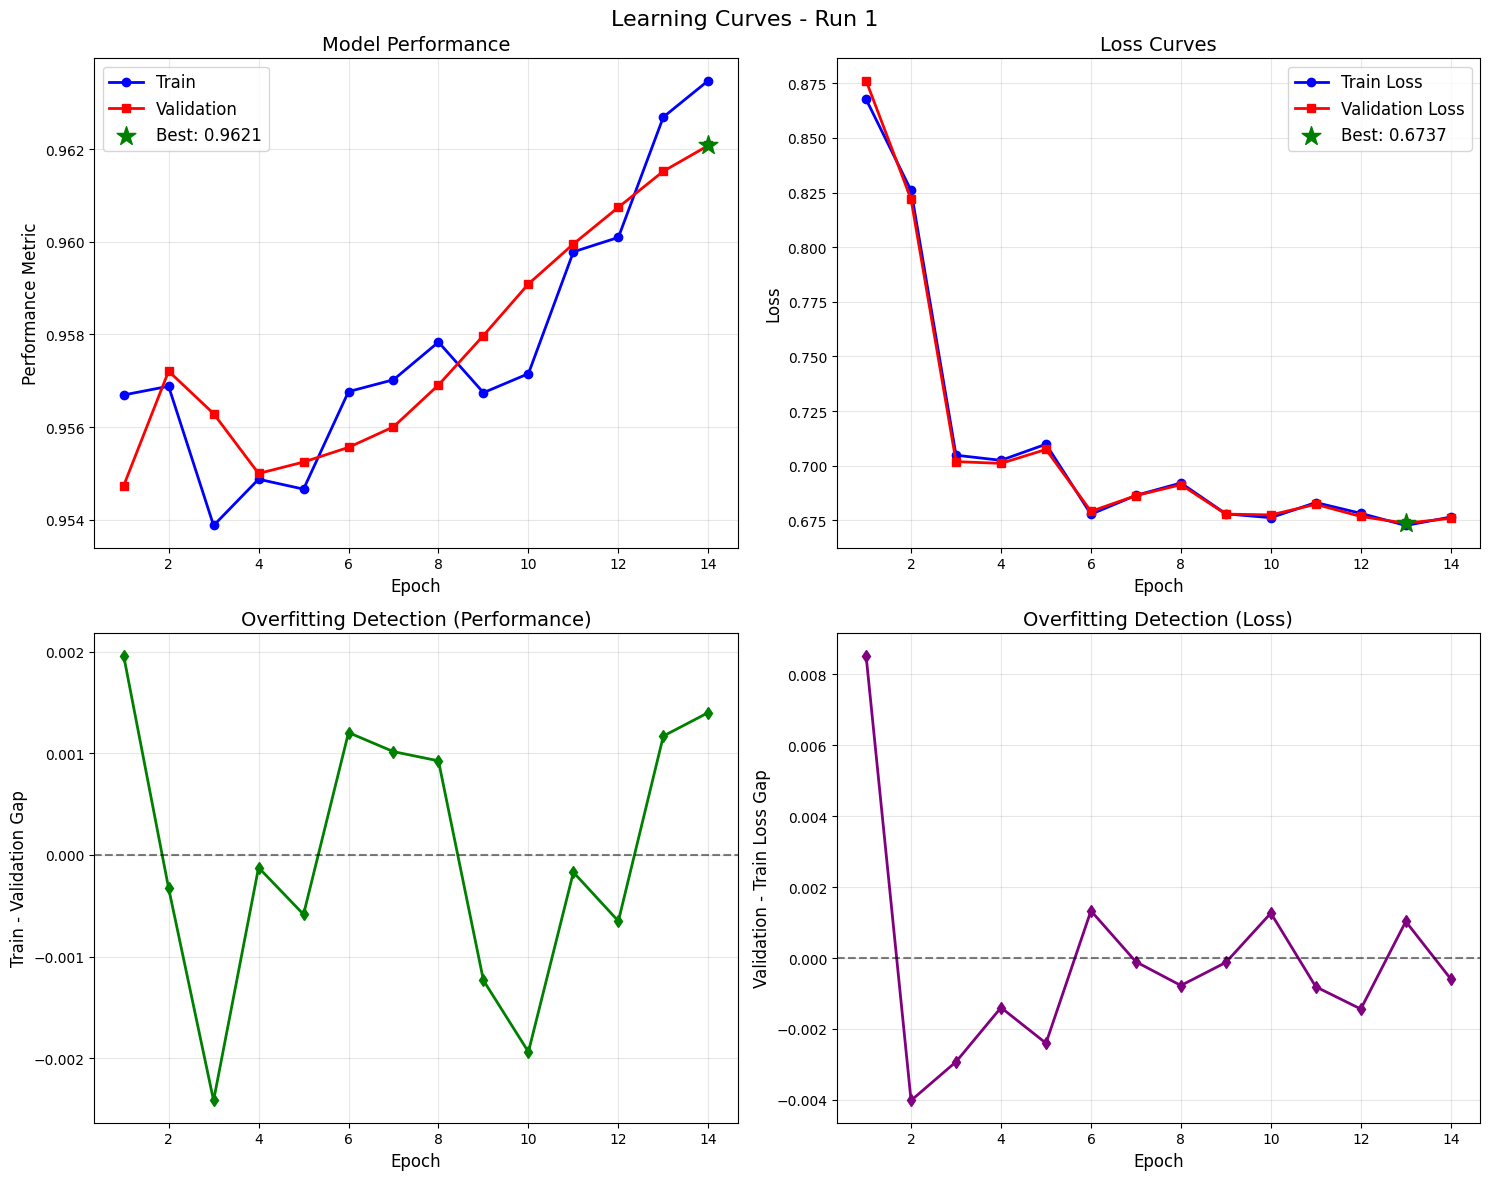

start testing!...
NDCG: 0.9628
test-result = 0.9628, test-logloss = 0.6759
test_auc [np.float64(0.9628208686336569)]
test_log_loss [np.float64(0.6758978796975007)]
avg_auc 0.9628208686336569
avg_log_loss 0.6758978796975007


In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# 명령행 인자 파싱
# args = parse_args()
print(args.__dict__) # 모든 인자 출력
print('**************')

# 데이터셋별 파일 이름 설정
# if args.data in ['Avazu']:
#     # Avazu는 수치형 특성이 없어서 스케일링하지 않음
#     file_name = ['train_i.npy', 'train_x.npy', 'train_y.npy']
# elif args.data in ['Criteo', 'KDD2012']:
#     # Criteo와 KDD2012는 스케일링된 데이터 사용 (train_x2.npy)
file_name = ['train_i.npy', 'train_x2.npy', 'train_y.npy']

# 결과 저장 리스트
test_auc = [] # AUC 점수들
test_log = [] # log loss들

# 여러 실행 결과 저장을 위한 리스트
all_models = []

print('run time : %d' % args.run_times)

# 여러 번 실행하여 평균 성능 계산 (실험의 신뢰성 향상)
for i in range(1, args.run_times + 1):
    test_result, test_loss, model = _run_(args, file_name, i)
    test_auc.append(test_result)
    test_log.append(test_loss)

    # 모델 저장 (나중에 비교를 위해)
    if args.run_times > 1:
        all_models.append(model)  # 모델 인스턴스 저장

# 최종 결과 출력
print('test_auc', test_auc)
print('test_log_loss', test_log)
print('avg_auc', sum(test_auc)/len(test_auc)) # 평균 AUC
print('avg_log_loss', sum(test_log)/len(test_log)) # 평균 log loss

# 여러 실행 결과 비교 (run_times > 1인 경우)
if args.run_times > 1 and all_models:
    compare_multiple_runs(all_models)

In [ ]:
# 예측값 분포 확인
Xi_test = np.load(config.DATA_PATH + '/part1/' + file_name[0])
Xv_test = np.load(config.DATA_PATH + '/part1/' + file_name[1])
y_pred = model.predict(Xi_test, Xv_test)
print("Prediction stats:")
print(f"Min: {y_pred.min():.4f}, Max: {y_pred.max():.4f}")
print(f"Mean: {y_pred.mean():.4f}, Std: {y_pred.std():.4f}")
print("\nPrediction distribution:")
print(np.histogram(y_pred, bins=10))

Prediction stats:
Min: 0.3981, Max: 0.6490
Mean: 0.5182, Std: 0.0543

Prediction distribution:
(array([ 12,  75, 327, 313, 210,  76, 210, 203,  98,  30]), array([0.398101  , 0.42319575, 0.4482905 , 0.47338527, 0.49848002,
       0.52357477, 0.5486695 , 0.57376426, 0.598859  , 0.62395376,
       0.6490485 ], dtype=float32))


# 실제 추천

In [ ]:
# recommendation_with_autoint.py
"""
AutoInt 모델을 사용한 의자 추천 시스템
"""

import numpy as np
import pandas as pd
import json
import os
from datetime import datetime
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from argparse import Namespace

# 제공된 코드의 클래스들
# from paste import DataPreprocessor
# from paste_4 import AutoInt
# from paste_3 import LearningCurveVisualizer

def load_test_data_and_chairs():
    """테스트 데이터와 의자 데이터 로드"""
    # Person 테스트 데이터 로드
    person_test_df = pd.read_excel('person_test.xlsx', engine='openpyxl')
    
    # cm -> mm 변환
    person_features = [
        'human-height', 'A_Buttock-popliteal length',
        'B_Popliteal-height', 'C_Hip-breadth',
        'F_Sitting-height', 'G_Shoulder-breadth'
    ]
    
    for col in person_features:
        if col in person_test_df.columns:
            person_test_df[col] *= 10
    
    # Chair 데이터 로드
    chair_df = pd.read_excel('chair_dummy.xlsx', engine='openpyxl')
    
    # 메타데이터 로드
    with open('processed_data/metadata.json', 'r') as f:
        metadata = json.load(f)
    
    return person_test_df, chair_df, metadata

def calculate_interaction_features(person_row, chair_row):
    """상호작용 피처 계산 (DataPreprocessor에서 가져옴)"""
    def safe_divide(numerator, denominator, default=0.0):
        if denominator > 0:
            return numerator / denominator
        return default
    
    features = {}
    
    # 높이 적합도
    h8_mid = (chair_row['h8_지면-좌석 높이_MIN'] + chair_row['h8_지면-좌석 높이_MAX']) / 2
    h8_range = chair_row['h8_지면-좌석 높이_MAX'] - chair_row['h8_지면-좌석 높이_MIN']
    popliteal_height = person_row['B_Popliteal-height']
    
    if h8_range > 0:
        if chair_row['h8_지면-좌석 높이_MIN'] <= popliteal_height <= chair_row['h8_지면-좌석 높이_MAX']:
            features['height_match_score'] = 1.0
        else:
            if popliteal_height < chair_row['h8_지면-좌석 높이_MIN']:
                dist = chair_row['h8_지면-좌석 높이_MIN'] - popliteal_height
            else:
                dist = popliteal_height - chair_row['h8_지면-좌석 높이_MAX']
            features['height_match_score'] = max(0, 1 - dist / 100)
    else:
        features['height_match_score'] = max(0, 1 - abs(h8_mid - popliteal_height) / 50)
    
    # 기타 피처들
    features['width_margin_ratio'] = safe_divide(
        chair_row['b3_좌석 가로 길이'] - person_row['C_Hip-breadth'], 
        person_row['C_Hip-breadth']
    )
    features['depth_margin_ratio'] = safe_divide(
        person_row['A_Buttock-popliteal length'] - chair_row['t4_좌석 세로 길이 일반'], 
        person_row['A_Buttock-popliteal length']
    )
    features['backrest_height_ratio'] = safe_divide(
        chair_row['h7_등받이 세로 길이'], 
        person_row['F_Sitting-height']
    )
    features['shoulder_width_ratio'] = safe_divide(
        chair_row['b4_등받이 가로 길이'], 
        person_row['G_Shoulder-breadth']
    )
    features['adjustable_range'] = h8_range
    
    return features

def create_feature_vectors(person_row, chair_row, metadata):
    """피처 벡터 생성"""
    values = []
    indices = []
    
    feature_idx_map = metadata['feature_mappings']
    person_features = metadata['person_features']
    numerical_features = metadata['chair_numerical_features']
    categorical_features = metadata['categorical_features']
    
    # 1. Person 수치형 피처
    for feat in person_features:
        if feat in person_row.index:
            values.append(str(person_row[feat]))
            indices.append(str(feature_idx_map[f'person_{feat}']))
    
    # 2. Chair 수치형 피처
    for feat in numerical_features:
        values.append(str(chair_row[feat]))
        indices.append(str(feature_idx_map[f'chair_{feat}']))
    
    # 3. 상호작용 피처
    interaction_feats = calculate_interaction_features(person_row, chair_row)
    for feat_name, feat_value in interaction_feats.items():
        values.append(str(feat_value))
        indices.append(str(feature_idx_map[feat_name]))
    
    # 4. 이진 범주형 피처
    for feat in categorical_features:
        values.append('1')
        
        # 범주형 값을 0/1로 변환
        if pd.isna(chair_row[feat]):
            feat_value = 0
        elif feat == '등받이 곧/꺾':
            # '곧'=0, '꺾'=1로 매핑
            feat_value = 0 if chair_row[feat] == '곧' else 1
        else:
            # 'O'=1, 'X'=0으로 매핑
            feat_value = 1 if chair_row[feat] == 'O' else 0
            
        idx_key = f'{feat}_{feat_value}'
        indices.append(str(feature_idx_map[idx_key]))
    
    return values, indices

def train_autoint_model():
    """AutoInt 모델 학습"""
    print("AutoInt 모델 학습 시작...")
    
    # 데이터 로드
    Xi_list, Xv_list, y_list = [], [], []
    
    with open('processed_data/train_i.txt', 'r') as f_i, \
         open('processed_data/train_x.txt', 'r') as f_x, \
         open('processed_data/train_y.txt', 'r') as f_y:
        
        # 빠른 테스트를 위해 일부만 사용
        max_samples = 5000
        for i, (line_i, line_x, line_y) in enumerate(zip(f_i, f_x, f_y)):
            if i >= max_samples:
                break
            Xi_list.append([int(x) for x in line_i.strip().split()])
            Xv_list.append([float(x) for x in line_x.strip().split()])
            y_list.append(float(line_y.strip()))
    
    Xi = np.array(Xi_list)
    Xv = np.array(Xv_list)
    y = np.array(y_list)
    
    # 데이터 분할
    split_idx = int(len(y) * 0.8)
    Xi_train, Xi_valid = Xi[:split_idx], Xi[split_idx:]
    Xv_train, Xv_valid = Xv[:split_idx], Xv[split_idx:]
    y_train, y_valid = y[:split_idx], y[split_idx:]
    
    # 하이퍼파라미터 설정
    args = Namespace(
        is_save=True,
        greater_is_better=True,
        has_residual=True,
        blocks=2,
        block_shape=[16, 16],
        heads=2,
        embedding_size=16,
        dropout_keep_prob=[1.0, 1.0, 0.5],
        epoch=5,
        batch_size=512,
        learning_rate=0.001,
        optimizer_type='adam',
        l2_reg=0.0,
        random_seed=42,
        save_path='./autoint_model/',
        field_size=Xi.shape[1],
        loss_type='ranking_ndcg',
        verbose=1,
        run_times=1,
        deep_layers=None,
        batch_norm=0,
        batch_norm_decay=0.995
    )
    
    os.makedirs(args.save_path, exist_ok=True)
    
    # 특성 크기
    feature_size = int(Xi.max() + 1)
    
    # 모델 생성
    model = AutoInt(args=args, feature_size=feature_size, run_cnt=1)
    
    # 학습
    for epoch in range(args.epoch):
        print(f"\nEpoch {epoch+1}/{args.epoch}")
        model.fit_once(
            Xi_train, Xv_train, y_train,
            epoch+1, 1,
            Xi_valid, Xv_valid, y_valid,
            early_stopping=False
        )
    
    print(f"\n학습 완료! 최종 검증 점수: {model.valid_result[-1]:.4f}")
    
    return model

def recommend_chairs_for_users(model, person_test_df, chair_df, metadata):
    """각 사용자에게 의자 추천"""
    recommendations = {}
    
    print("\n추천 생성 중...")
    
    for person_idx, person_row in person_test_df.iterrows():
        person_id = person_row.get('image-name', f'Person_{person_idx}')
        print(f"  - {person_id} 처리 중...")
        
        # 각 의자에 대한 점수 계산
        chair_scores = []
        
        for chair_idx, chair_row in chair_df.iterrows():
            # 피처 벡터 생성
            values, indices = create_feature_vectors(person_row, chair_row, metadata)
            
            # 모델 입력 형식으로 변환
            Xi = np.array([[int(idx) for idx in indices]])
            Xv = np.array([[float(val) for val in values]])
            
            # 예측
            score = model.predict(Xi, Xv)[0]
            
            # 의자 정보 저장
            chair_info = {
                'chair_idx': chair_idx,
                'chair_name': f'Chair_{chair_idx}',  # 실제 의자 이름이 있다면 사용
                'score': float(score),
                'specs': {
                    'height_range': f"{chair_row['h8_지면-좌석 높이_MIN']}-{chair_row['h8_지면-좌석 높이_MAX']}mm",
                    'seat_width': f"{chair_row['b3_좌석 가로 길이']}mm",
                    'seat_depth': f"{chair_row['t4_좌석 세로 길이 일반']}mm",
                    'backrest_height': f"{chair_row['h7_등받이 세로 길이']}mm",
                    'backrest_width': f"{chair_row['b4_등받이 가로 길이']}mm"
                }
            }
            chair_scores.append(chair_info)
        
        # 점수 기준 정렬
        chair_scores.sort(key=lambda x: x['score'], reverse=True)
        
        # Top-5 선택
        recommendations[person_id] = {
            'person_specs': {
                'height': f"{person_row['human-height']/10:.1f}cm",
                'popliteal_height': f"{person_row['B_Popliteal-height']/10:.1f}cm",
                'hip_breadth': f"{person_row['C_Hip-breadth']/10:.1f}cm",
                'sitting_height': f"{person_row['F_Sitting-height']/10:.1f}cm",
                'shoulder_breadth': f"{person_row['G_Shoulder-breadth']/10:.1f}cm"
            },
            'top_5_chairs': chair_scores[:5]
        }
    
    return recommendations

def display_recommendations(recommendations):
    """추천 결과 출력"""
    print("\n" + "="*80)
    print("🪑 의자 추천 결과")
    print("="*80)
    
    for person_id, rec_data in recommendations.items():
        print(f"\n👤 {person_id}")
        print(f"📏 신체 정보: {', '.join([f'{k}={v}' for k, v in rec_data['person_specs'].items()])}")
        print(f"\n🎯 Top-5 추천 의자:")
        
        for i, chair in enumerate(rec_data['top_5_chairs'], 1):
            print(f"\n  {i}. {chair['chair_name']} (점수: {chair['score']:.4f})")
            print(f"     크기: {chair['specs']['seat_width']} x {chair['specs']['seat_depth']}")
            print(f"     높이: {chair['specs']['height_range']}")
            print(f"     등받이: {chair['specs']['backrest_height']} x {chair['specs']['backrest_width']}")

def save_recommendations(recommendations):
    """추천 결과 저장"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # JSON 저장
    json_path = f'chair_recommendations_{timestamp}.json'
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(recommendations, f, ensure_ascii=False, indent=2)
    print(f"\n💾 JSON 저장: {json_path}")
    
    # CSV 저장
    csv_data = []
    for person_id, rec_data in recommendations.items():
        for rank, chair in enumerate(rec_data['top_5_chairs'], 1):
            csv_data.append({
                'Person_ID': person_id,
                'Person_Height': rec_data['person_specs']['height'],
                'Rank': rank,
                'Chair_Name': chair['chair_name'],
                'Score': chair['score'],
                'Height_Range': chair['specs']['height_range'],
                'Seat_Size': f"{chair['specs']['seat_width']} x {chair['specs']['seat_depth']}"
            })
    
    csv_df = pd.DataFrame(csv_data)
    csv_path = f'chair_recommendations_{timestamp}.csv'
    csv_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"📊 CSV 저장: {csv_path}")

def main():
    """메인 실행 함수"""
    print("🚀 AutoInt 기반 의자 추천 시스템")
    print("="*80)
    
    # 1. 데이터 로드
    print("\n[1/4] 데이터 로드 중...")
    person_test_df, chair_df, metadata = load_test_data_and_chairs()
    print(f"  - 테스트 사용자 수: {len(person_test_df)}")
    print(f"  - 의자 수: {len(chair_df)}")
    
    # 2. 모델 학습 또는 로드
    print("\n[2/4] 모델 준비 중...")
    model_path = './autoint_model/'
    
    if os.path.exists(model_path + '1/'):
        # 저장된 모델 로드
        print("  - 저장된 모델 로드 중...")
        # 모델 설정
        args = Namespace(
            is_save=False,
            greater_is_better=True,
            has_residual=True,
            blocks=2,
            block_shape=[16, 16],
            heads=2,
            embedding_size=16,
            dropout_keep_prob=[1.0, 1.0, 1.0],
            epoch=0,
            batch_size=512,
            learning_rate=0.001,
            optimizer_type='adam',
            l2_reg=0.0,
            random_seed=42,
            save_path='./autoint_model/',
            field_size=metadata['numerical_features'] + len(metadata['categorical_features']),
            loss_type='ranking_ndcg',
            verbose=0,
            run_times=1,
            deep_layers=None,
            batch_norm=0,
            batch_norm_decay=0.995
        )
        
        feature_size = metadata['total_features']
        model = AutoInt(args=args, feature_size=feature_size, run_cnt=1)
        model.restore()
    else:
        # 새로 학습
        print("  - 새로운 모델 학습 중...")
        model = train_autoint_model()
    
    # 3. 추천 생성
    print("\n[3/4] 추천 생성 중...")
    recommendations = recommend_chairs_for_users(model, person_test_df, chair_df, metadata)
    
    # 4. 결과 출력 및 저장
    print("\n[4/4] 결과 처리 중...")
    display_recommendations(recommendations)
    save_recommendations(recommendations)
    
    print("\n✅ 완료!")
    return recommendations

# if __name__ == "__main__":
#     # TensorFlow 로그 레벨 설정
#     os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    
    # 실행
recommendations = main()

🚀 AutoInt 기반 의자 추천 시스템

[1/4] 데이터 로드 중...
  - 테스트 사용자 수: 4
  - 의자 수: 1000000

[2/4] 모델 준비 중...
  - 새로운 모델 학습 중...
AutoInt 모델 학습 시작...
total parameters :3121
extra parameters : 2625

Epoch 1/5
NDCG: 0.9467
NDCG: 0.9278
[1-1] model saved!. Valid loss is improved from 1.0000 to 0.6951
[1-1] train-result=0.9467, train-logloss=0.6950, valid-result=0.9278, valid-logloss=0.6951 [0.6 s]

Epoch 2/5
NDCG: 0.9532
NDCG: 0.9281
[2-1] model saved!. Valid loss is improved from 0.6951 to 0.6876
[2-1] train-result=0.9532, train-logloss=0.6852, valid-result=0.9281, valid-logloss=0.6876 [0.3 s]

Epoch 3/5
NDCG: 0.9534
NDCG: 0.9320
[3-1] train-result=0.9534, train-logloss=0.6852, valid-result=0.9320, valid-logloss=0.6879 [0.3 s]

Epoch 4/5
NDCG: 0.9648
NDCG: 0.9464
[4-1] model saved!. Valid loss is improved from 0.6876 to 0.6853
[4-1] train-result=0.9648, train-logloss=0.6833, valid-result=0.9464, valid-logloss=0.6853 [0.3 s]

Epoch 5/5
NDCG: 0.9750
NDCG: 0.9640
[5-1] model saved!. Valid loss is improved 